# 使用Tensoflow2实现GAT

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import networkx as nx
import pickle

import tensorflow as tf
from tensorflow import keras
import warnings

# 1. 数据导入

依旧使用Cora数据集，跟GCN的实现中一样，所有这里仅仅只是把GCN实现中的代码搬了过来

In [2]:
content_path = '../datasets/cora/cora.content'
cite_path = '../datasets/cora/cora.cites'
data_dir = '../datasets/cora'
os.path.exists(content_path), os.path.exists(cite_path)

(True, True)

In [3]:
with open(content_path, 'r') as f:
    contents = f.readlines()
with open(cite_path, 'r') as f:
    cites = f.readlines()
contents = np.array([l.strip().split('\t') for l in contents])
cites_raw = np.array([i.strip().split('\t') for i in cites])

In [4]:
papers_raw, features_raw, labels_raw = np.split(contents, [1, -1], axis=1)
features = features_raw.astype(np.float32)

paper_dict = {key:value for value, key in enumerate(np.squeeze(papers_raw))}
label_dict = {key:value for value, key in enumerate(np.unique(np.squeeze(labels_raw)))}

papers = np.array([[paper_dict[key]] for key in papers_raw.reshape(-1)])
labels = np.array([[label_dict[key]] for key in labels_raw.reshape(-1)])

cites = np.array([[paper_dict[i[0]], paper_dict[i[1]]] for i in cites_raw])
node_num = len(papers)
label_num = len(label_dict.keys())
feature_dim = features.shape[1]
edge_num = len(cites)

print('{:=^30}'.format('图数据信息'))
print('节点数量：', node_num)
print('边数量：', edge_num)
print('特征维数：', feature_dim)
print('标签类别数量：', label_num)
print('标签类别：')
for label in label_dict.keys():
    print('{: <5}- {:<}'.format('', label))

============图数据信息=============
节点数量： 2708
边数量： 5429
特征维数： 1433
标签类别数量： 7
标签类别：
     - Case_Based
     - Genetic_Algorithms
     - Neural_Networks
     - Probabilistic_Methods
     - Reinforcement_Learning
     - Rule_Learning
     - Theory


In [5]:
label_dict

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [6]:
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [7]:
papers.shape, labels.shape, cites.shape, features.shape

((2708, 1), (2708, 1), (5429, 2), (2708, 1433))

In [8]:
node_num, edge_num, label_num, feature_dim

(2708, 5429, 7, 1433)

# 2. 构造邻接矩阵

In [9]:
G = nx.Graph()
G.add_nodes_from(range(len(papers)))
G.add_edges_from(cites)
adj_matrix = nx.adjacency_matrix(G)

In [10]:
adj_matrix.shape, type(adj_matrix)

((2708, 2708), scipy.sparse.csr.csr_matrix)

In [11]:
# 将稀疏矩阵转为普通矩阵，并引入自环边，构造带自环的邻接矩阵
A = adj_matrix.toarray()
A = A + np.eye(A.shape[0])
A

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [12]:
print(f'节点数：{node_num}')

节点数：2708


# 3. 数据集分割

使用同论文中相同的数据集分割方式：
- 训练集：**每个类别中取出20个**作为训练集（共140）
- 验证集：剩下数据集中取出**500个**
- 测试集：剩下数据集中取出**1000个**

由于计算时是需要所有的图数据和特征，所以数据集分割采用的是mask数组，**只在算损失和准确率时使用**

In [13]:
import gc
import random

from functools import reduce

In [14]:
labels_ = labels.ravel()

In [15]:
# 构建训练、验证、测试索引集合
train_index, valid_index, test_index = [], [], []
# 每类取出20个样本
for cate in label_dict.values():
    indexes = np.arange(node_num)
    indexes = indexes[labels_ == cate]
    indexes = np.random.choice(indexes, 20, replace=False)
    train_index.append(indexes)
train_index = np.hstack(train_index)
np.random.shuffle(train_index)
valid_index = np.random.choice(np.setdiff1d(np.arange(node_num), train_index), 500, replace=False)
test_index = np.random.choice(reduce(np.setdiff1d, [np.arange(node_num), train_index, valid_index]), 
                             1000, replace=False)

In [16]:
mask = np.zeros(shape=(node_num))
train_mask = mask.copy()
valid_mask = mask.copy()
test_mask = mask.copy()

train_mask[train_index] = 1
valid_mask[valid_index] = 1
test_mask[test_index] = 1

----

数据集分割完成

---

In [17]:
# 为方便后续使用，将处理好的数据进行离线保存
cora_data = {'features': features, 'labels': labels, 'A': A,
       'train_mask': train_mask, 'valid_mask': valid_mask, 'test_mask': test_mask, 'node_num': node_num, 
       'edge_num': edge_num, 'label_num': label_num, 'feature_dim': feature_dim}

import pickle 
pickle.dump(cora_data, open(os.path.join(data_dir, 'cora_data.pkl'), 'wb'))
print('{:=^50}'.format('数据导入完成'))

======================数据导入完成======================


In [18]:
cora_data

{'features': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'labels': array([[2],
        [5],
        [4],
        ...,
        [1],
        [0],
        [2]]),
 'A': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 'train_mask': array([0., 0., 0., ..., 0., 0., 0.]),
 'valid_mask': array([0., 0., 0., ..., 1., 0., 0.]),
 'test_mask': array([1., 1., 0., ..., 0., 0., 0.]),
 'node_num': 2708,
 'edge_num': 5429,
 'label_num': 7,
 'feature_dim': 1433}

# 4. 模型层构建

GAT实验设置：

- 参数初始化：Glorot
- 优化算法：Adam
- 学习率：0.005
- 提早停止：True
- epochs：100
- 层数：2
- 第一层：8heads，$F\prime = 8$，64个输出特征，ELU作激活函数
- 第二层：1heads，$F\prime = classes$，$classes$个输出特征，softmax激活函数
- 正则化：L2，$\lambda = 0.0005$
- Dropout：0.6，用在每层输入和**规范化注意力系数**

GCN实验设置：

计算公式：$$Z = softmax(\hat A ReLU(\hat A X W^{(0)})W^{(1)}))$$

- Dropout：0.5，所有层
- 正则化：L2，$\lambda = 0.0005$，第一层
- 隐层数：1
- 隐层神经元数：16

In [29]:
class GAT_conv(keras.layers.Layer):
    def __init__(self, units, 
                 activation='elu', 
                 use_bias=False, 
                 attention_heads=1, 
                 attention_reduction='concat', 
                 kernel_regularizer=None,
                 bias_regularizer=None, 
                 attn_kernel_regularizer=None, 
                 kernel_constraint=None,
                 bias_constraint=None, 
                 attn_kernel_constraint=None,
                 dropout_rate=0.6, 
                 kernel_initializer='glorot_uniform', 
                 bias_initializer='zeros', 
                 **kwargs):
        self.units = units
        self.attention_heads = attention_heads
        self.attention_reduction = attention_reduction
        self.dropout_rate = dropout_rate
        self.kernel_initializer = kernel_initializer
        self.use_bias = use_bias
        self.bias_initializer = bias_initializer
        self.activation = keras.activations.get(activation)
        
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)
        self.attn_kernel_regularizer = keras.regularizers.get(attn_kernel_regularizer)

        self.kernel_constraint = keras.constraints.get(kernel_constraint)
        self.bias_constraint = keras.constraints.get(bias_constraint)
        self.attn_kernel_constraint = keras.constraints.get(attn_kernel_constraint)
        
        
        if attention_reduction == 'concat':
            # concat multi-heads
            self.output_dim = self.units * self.attention_heads
        else:
            # average multi-heads
            self.output_dim = self.units
        
        self.kernels = []
        self.bias = []
        self.attention_kernels = []
        
        super().__init__(**kwargs)
    
    
    def build(self, input_shape):
        for head in range(self.attention_heads):
            kernel = self.add_weight(shape=(input_shape[0][-1], self.units), 
                                     initializer=self.kernel_initializer,
                                     regularizer=self.activity_regularizer,
                                     name='kernel_head{}'.format(head))
            self.kernels.append(kernel)
            if self.use_bias:
                bias = self.add_weight(shape=(self.units, ),
                                      initializer=self.bias_initializer,
                                      regularizer=self.activity_regularizer,
                                      name='bias_head{}'.format(head))
                self.bias.append(bias)
            
            attention_kernel_self = self.add_weight(shape=(self.units, 1),
                                                   initializer=self.kernel_initializer,
                                                   regularizer=self.attn_kernel_regularizer,
                                                   constraint=self.attn_kernel_constraint,
                                                   name='attention_kernel_self_head{}'.format(head))
            attention_kernel_neighbors = self.add_weight(shape=(self.units, 1),
                                                         initializer=self.kernel_initializer,
                                                         regularizer=self.attn_kernel_regularizer,
                                                         constraint=self.attn_kernel_constraint,
                                                         name='attention_kernel_neighbors_head{}'.format(head))
            self.attention_kernels.append([attention_kernel_self, attention_kernel_neighbors])
            self.built = True
        
    def call(self, inputs, training=False):
        X, A = inputs # [nxd, nxn]
        outputs = []
        for head in range(self.attention_heads):
            kernel = self.kernels[head] # dxd'
            attention_kernel = self.attention_kernels[head] # [d'x1, d'x1]
            
            features = X @ kernel # nxd'
            attention_self = features @ attention_kernel[0] # nx1
            attention_neighbors = features @ attention_kernel[1] # nx1
            
            
            a_weight = attention_self + tf.transpose(attention_neighbors)
            a_weight = tf.nn.leaky_relu(a_weight, alpha=0.2)
            #  a_weight *= A # 掩码，去掉无连接关系的值
            a_weight += -10e9 * (1.0-A) # 处理softmax中的无连接位置的值
             
            a_weight = tf.nn.softmax(a_weight)
            
            dropout_attention = keras.layers.Dropout(self.dropout_rate)(a_weight, training=training) # nxn
#             dropout_features = keras.layers.Dropout(self.dropout_rate)(features, training=training) # nxd'
            dropout_features = keras.layers.Dropout(0.0)(features, training=training) # nxd'

            
            
            node_features = dropout_attention @ dropout_features # nxd'
            
            if self.use_bias:
                node_features += self.bias[head] # nxd'
            outputs.append(node_features)
            
        if self.attention_reduction == 'concat':
            output = tf.concat(outputs, axis=1)
        else:
            output = tf.reduce_mean(outputs, axis=0)
        return self.activation(output)
    
    def compute_output_shape(self, input_shape):
        output_shape = input_shape[0][0], self.output_dim
        return output_shape

# 5. 模型层构建

In [30]:
def gat(hidden_size=64, dropout_rate=0.0, att_heads=8, use_bias=True, l2_reg=tf.keras.regularizers.l2(5e-4/2)):
    X_input = keras.Input(shape=(feature_dim, ))
    A_input = keras.Input(shape=(node_num, ))
    
    dropout1 = keras.layers.Dropout(dropout_rate)(X_input)
    z = GAT_conv(units=hidden_size, activation='elu', dropout_rate=dropout_rate, kernel_regularizer=l2_reg,
                 attention_reduction='concat', 
                 attention_heads=att_heads)([dropout1, A_input])
    dropout2 = keras.layers.Dropout(dropout_rate)(z)
    z = GAT_conv(units=label_num, activation='softmax', kernel_regularizer=l2_reg,
                 attention_reduction='mean', dropout_rate=dropout_rate, 
                 attention_heads=1)([dropout2, A_input])
    model = keras.Model(inputs=[X_input, A_input], outputs=z, name='GAT_model')
    return model

# 6. 模型编译、训练、评估

In [21]:
cora_data.keys()

dict_keys(['features', 'labels', 'A', 'train_mask', 'valid_mask', 'test_mask', 'node_num', 'edge_num', 'label_num', 'feature_dim'])

In [22]:
features = cora_data['features']
labels = cora_data['labels']

features = tf.convert_to_tensor(features, tf.float32)
labels = tf.convert_to_tensor(labels, tf.int32)
train_mask = tf.cast(cora_data['train_mask'], tf.float32)
val_mask = tf.cast(cora_data['valid_mask'], tf.float32)
test_mask = tf.cast(cora_data['test_mask'], tf.float32)

Epoch 1/1000
1/1 - 1s - loss: 0.1102 - acc: 0.1786 - val_loss: 0.3437 - val_acc: 0.3960
Epoch 2/1000
1/1 - 0s - loss: 0.1030 - acc: 0.2500 - val_loss: 0.3255 - val_acc: 0.4960
Epoch 3/1000
1/1 - 0s - loss: 0.0951 - acc: 0.3000 - val_loss: 0.3075 - val_acc: 0.5680
Epoch 4/1000
1/1 - 0s - loss: 0.0922 - acc: 0.3714 - val_loss: 0.2902 - val_acc: 0.6500
Epoch 5/1000
1/1 - 0s - loss: 0.0881 - acc: 0.4214 - val_loss: 0.2745 - val_acc: 0.7140
Epoch 6/1000
1/1 - 0s - loss: 0.0864 - acc: 0.4500 - val_loss: 0.2578 - val_acc: 0.7740
Epoch 7/1000
1/1 - 0s - loss: 0.0795 - acc: 0.5286 - val_loss: 0.2427 - val_acc: 0.7920
Epoch 8/1000
1/1 - 0s - loss: 0.0719 - acc: 0.5714 - val_loss: 0.2290 - val_acc: 0.7980
Epoch 9/1000
1/1 - 0s - loss: 0.0758 - acc: 0.5071 - val_loss: 0.2171 - val_acc: 0.7940
Epoch 10/1000
1/1 - 0s - loss: 0.0706 - acc: 0.5000 - val_loss: 0.2064 - val_acc: 0.7980
Epoch 11/1000
1/1 - 0s - loss: 0.0610 - acc: 0.6143 - val_loss: 0.1966 - val_acc: 0.7960
Epoch 12/1000
1/1 - 0s - loss:

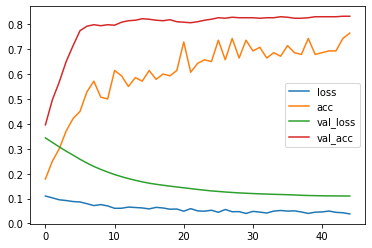

In [35]:
dropout_rate = 0.7
epochs = 1000
es_patience = 10
es_min_delta = 0.01
lr=0.005

model = gat(dropout_rate=dropout_rate, use_bias=False)

optimizer = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              weighted_metrics=['acc'])

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=es_patience, 
                                            min_delta=es_min_delta)

val_data = ([features, A], labels, val_mask)
history = model.fit([features, A], labels, sample_weight=train_mask, validation_data=val_data,
          batch_size=node_num, epochs=epochs, verbose=2, shuffle=False, callbacks=es_callback)
print()
for i in [train_mask, val_mask, test_mask]:
    print(model.evaluate([features, A], labels, sample_weight=i, batch_size=node_num, verbose=2))

for i, item in history.history.items():
    plt.plot(item, label=i)
plt.legend()

In [36]:
for i in [train_mask, val_mask, test_mask]:
    print(model.evaluate([features, A], labels, sample_weight=i, batch_size=node_num, verbose=2))

1/1 - 0s - loss: 0.0080 - acc: 0.9714
[0.00803146418184042, 0.9714285731315613]
1/1 - 0s - loss: 0.1103 - acc: 0.8320
[0.11029516160488129, 0.8320000171661377]
1/1 - 0s - loss: 0.2293 - acc: 0.8210
[0.22929000854492188, 0.8209999799728394]


----

自定义损失函数、评估函数和训练

-----

In [37]:
# 构建损失函数、评估（准确率）函数
def masked_sparse_cross_entropy(preds, labels, mask):
    """预测结果是概率形式，标签是正确类型，计算"""
    mask = tf.cast(mask, tf.bool)
    loss = - tf.math.log(tf.clip_by_value(preds[mask], 1e-7, 1)) * tf.one_hot(tf.reshape(labels[mask], shape=(-1, )), 7)
    loss = tf.reduce_sum(loss, axis=1)
    loss = tf.reduce_mean(loss)
    '''
    或者
    keras.losses.SparseCategoricalCrossentropy(from_logits=False)(labels[mask], preds[mask])
    '''
    return loss

def masked_accuracy(preds, labels, mask):
    """Accuracy with masking."""
    mask = tf.cast(mask, tf.bool)
    correct = tf.equal(tf.cast(tf.argmax(preds[mask], axis=1), dtype=tf.int32), tf.reshape(labels[mask], shape=(-1, )))
    correct = tf.cast(correct, tf.float32)
    return tf.reduce_mean(correct)

====================Start of 1====================
acc: 0.3499999940395355 - loss: 1.802678108215332 - val_acc: 0.29600000381469727 - val_loss: 1.833546757698059
====================Start of 2====================
acc: 0.6428571343421936 - loss: 1.6457849740982056 - val_acc: 0.5600000023841858 - val_loss: 1.7034459114074707
====================Start of 3====================
acc: 0.800000011920929 - loss: 1.4932714700698853 - val_acc: 0.722000002861023 - val_loss: 1.5808579921722412
====================Start of 4====================
acc: 0.8285714387893677 - loss: 1.3525491952896118 - val_acc: 0.7480000257492065 - val_loss: 1.4678640365600586
====================Start of 5====================
acc: 0.8500000238418579 - loss: 1.2229682207107544 - val_acc: 0.7580000162124634 - val_loss: 1.364629864692688
====================Start of 6====================
acc: 0.8714285492897034 - loss: 1.1019967794418335 - val_acc: 0.7839999794960022 - val_loss: 1.2727385759353638
====================Start 

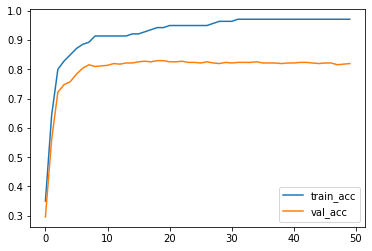

In [43]:
dropout_rate = 0.7

model = gat(dropout_rate=dropout_rate, use_bias=False)

optimizer = keras.optimizers.Adam(learning_rate=0.005)
train_accs = []
val_accs = []
train_losses = []
val_losses = []
for epoch in range(50):
    with tf.GradientTape() as tape:
        logits = model([features, A], training=True)
        loss = masked_sparse_cross_entropy(logits, labels, train_mask)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     if epoch % 10 == 0:
    print('{:=^50}'.format(f'Start of {epoch+1}'))
    

    # 计算准确率时，关掉dropout
    logits = model([features, A], training=False)
    loss = masked_sparse_cross_entropy(logits, labels, train_mask)
    acc = masked_accuracy(logits, labels, train_mask)
    train_accs.append(acc.numpy())
    train_losses.append(loss.numpy())
    val_acc = masked_accuracy(logits, labels, val_mask)
    val_loss = masked_sparse_cross_entropy(logits, labels, val_mask)
    val_accs.append(val_acc.numpy())
    val_losses.append(val_loss.numpy())
    print(f'acc: {acc.numpy()} - loss: {loss} - '
          f'val_acc: {val_acc.numpy()} - val_loss: {val_loss}')

logits = model([features, A], training=False)
acc_test = masked_accuracy(logits, labels, test_mask)
print('test_acc：', acc_test.numpy())

import matplotlib.pyplot as plt
plt.plot(train_accs)
plt.plot(val_accs)
plt.legend(['train_acc', 'val_acc'], loc='best')

In [44]:
model.summary()

Model: "GAT_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 1433)]       0                                            
__________________________________________________________________________________________________
dropout_10748 (Dropout)         (None, 1433)         0           input_25[0][0]                   
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 2708)]       0                                            
__________________________________________________________________________________________________
gat_conv_24 (GAT_conv)          (None, 512)          734720      dropout_10748[0][0]              
                                                                 input_26[0][0]           